## Matanzas_CRF_to_roughness

* Read in the results of the CRF pixel classification
* Use look-up table to assign roughness
* Interpolate onto the Delft model grid

In [1]:
import numpy as np
import pandas as pd
import rasterio # rasterio and OGR don't mix...see rasterio docs
import matplotlib.pyplot as plt
import xarray as xr
import scipy.io as sio
import scipy.signal
# from pyproj import Proj, transform
from scipy import interpolate

%matplotlib inline

### Load the image that was classified
This is needed for the projection and coordinates values of the classified image.

This image was generated by loading the NAIP imagery for an ROI slightly larger than the Delft grid into Global Mapper (v. 19) and saving as a geotiff file.

In [2]:
fn = r'..\naip.tif'
da = xr.open_rasterio(fn,chunks={'x':256, 'y':256})
da

<xarray.DataArray (band: 3, y: 9539, x: 16355)>
dask.array<shape=(3, 9539, 16355), dtype=uint8, chunksize=(3, 256, 256)>
Coordinates:
  * band     (band) int32 1 2 3
  * y        (y) float64 29.7 29.7 29.7 29.7 29.7 29.7 29.7 29.7 29.7 29.7 ...
  * x        (x) float64 -81.24 -81.24 -81.24 -81.24 -81.24 -81.24 -81.24 ...
Attributes:
    transform:   (3.144103494418427e-06, 0.0, -81.24381501674641, 0.0, -3.144...
    crs:         +init=epsg:4269
    res:         (3.144103494418427e-06, 3.144103494418295e-06)
    is_tiled:    0
    nodatavals:  (nan, nan, nan)

### Load the output from the CRF classification of the same image
This was generated by ```int_seg_crf_matanzas.py``` with user input.

In [3]:
m = sio.loadmat(r'..\naip_mres.mat')

In [4]:
np.shape(m['class'])

(9539, 16355)

### Make a dict to convert CRF class to Manning's n.

This is an approximation of Mattocks & Forbes (2008) Table 3.

See also https://github.com/csherwood-usgs/NLCD_to_Roughness/blob/master/NLCD_to_Roughness.ipynb

```
classes = {'sand':'d', 'wetland veg':'g', 'water':'y', 'dune grass':'v',\
   'woody vegetation':'n','structure':'q','road':'r','surf':'s'}
```

In [5]:
# The CRF program crashed while trying to write the output, but naip_mres.mat still included the classes.
# The class labels were not saved...recreate them:
labels = np.array(['sand            ', 'wetland veg     ', 'water           ',\
       'dune grass      ', 'woody vegetation',             'structure       ',\
       'road            ', 'surf            '], 
      dtype='<U16' )
labels

array(['sand            ', 'wetland veg     ', 'water           ',
       'dune grass      ', 'woody vegetation', 'structure       ',
       'road            ', 'surf            '], 
      dtype='<U16')

In [6]:
# These roughness assignments are up for some debate. In particular, MF2008 assign sand = 0.09, but I chose 0.02 (same as water)
# I also put structure at 0.05, because it is not well classified, and I did not want random big roughness elements.
n = {0: 0.02, 1: 0.045, 2: .02, 3: 0.034, 4: 0.05, 5: 0.1, 6: 0.09, 7: 0.02}


In [7]:
# initialize a float array with same shape as class array
nmap = 0.0*np.ones_like(m['class'])
(ni,nj)=np.shape(nmap)
print('Shapes of new np array and DataArray: ',np.shape(m['class']),np.shape(nmap))
print('Print number of rows, columns: ',ni,nj)

# loop through and assign Manning's n value to array using class look-up table
for i in range(ni):
    for j in range(nj):
        nmap[i,j]=n[m['class'][i,j]]
print('\nRoughness values:')
nmap

Shapes of new np array and DataArray:  (9539, 16355) (9539, 16355)
Print number of rows, columns:  9539 16355

Roughness values:


array([[ 0.045,  0.045,  0.045, ...,  0.02 ,  0.02 ,  0.02 ],
       [ 0.045,  0.045,  0.045, ...,  0.02 ,  0.02 ,  0.02 ],
       [ 0.045,  0.045,  0.045, ...,  0.02 ,  0.02 ,  0.02 ],
       ..., 
       [ 0.05 ,  0.05 ,  0.05 , ...,  0.02 ,  0.02 ,  0.02 ],
       [ 0.05 ,  0.05 ,  0.05 , ...,  0.02 ,  0.02 ,  0.02 ],
       [ 0.05 ,  0.05 ,  0.05 , ...,  0.02 ,  0.02 ,  0.02 ]])

### Quick plot of the roughness map

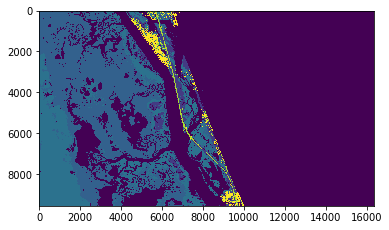

In [8]:
plt.imshow(nmap)

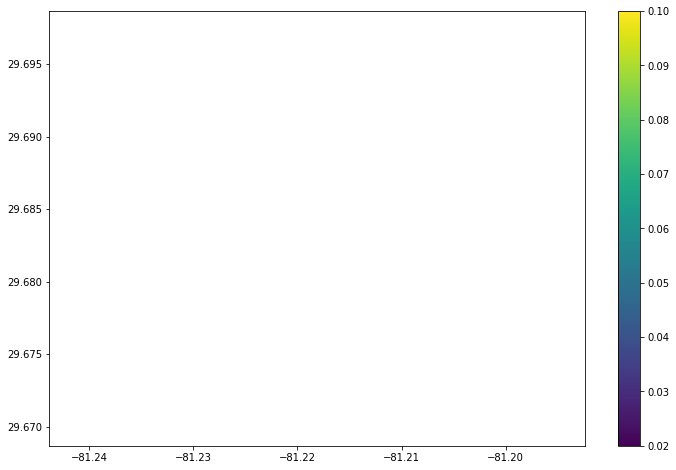

In [9]:
# not sure why this does not render
plt.figure(figsize=(12,8))
plt.pcolormesh(da['x'].values, da['y'].values, nmap, edgecolors='none',shading='flat')
plt.colorbar()

### Export the coords, classes, and roughness values to a Matlab file

In [10]:
sio.savemat('Matanzas_nmap.mat',{'lon': da['x'].values, 'lat': da['y'].values, 'n': nmap, 'class': m['class']},do_compression=True)

### Interpolate onto Delft grid

* Smooth the roughness grid first
* There will be a problem if the model grid extends beyond CRF grid
* Some roughness elements will need to be adjusted.

In [11]:
# smooth with 2D running median
nmapf = scipy.signal.medfilt2d(nmap, kernel_size=5)

In [12]:
# Read Delft grid...note these have different numbers of spaces separating the values
lat = np.genfromtxt(r'..\lat.txt',delimiter='   ')
lon = np.genfromtxt(r'..\lon.txt',delimiter='  ')
dep = np.genfromtxt(r'..\bed.dep',delimiter='  ')
print(np.shape(lat), np.shape(lon), np.shape(dep))
lat
lon
dep

(290, 422) (290, 422) (290, 422)


array([[-25., -25., -25., ...,  -6.,  -6.,  -6.],
       [-25., -25., -25., ...,  -6.,  -6.,  -6.],
       [-25., -25., -25., ...,  -6.,  -6.,  -6.],
       ..., 
       [-25., -25., -25., ...,  -6.,  -6.,  -6.],
       [-25., -25., -25., ...,  -6.,  -6.,  -6.],
       [-25., -25., -25., ...,  -6.,  -6.,  -6.]])

In [13]:
# The interpolation algorithms whines about the fact that y decreases, rather than increases...so flip y and nmapf
y = np.flipud(da['y'].values)
nmapf = np.flipud(nmapf)
f=interpolate.RegularGridInterpolator((y,da['x'].values), nmapf, method='nearest')

In [14]:
# Do the interpolation
cnmapi = f((lat,lon))

In [15]:
sio.savemat('Matanzas_nmap_interpolated.mat',{'lon': lon, 'lat': lat, 'n': cnmapi, 'dep': dep},do_compression=True)

Text(0.5,1,"Manning's $n$")

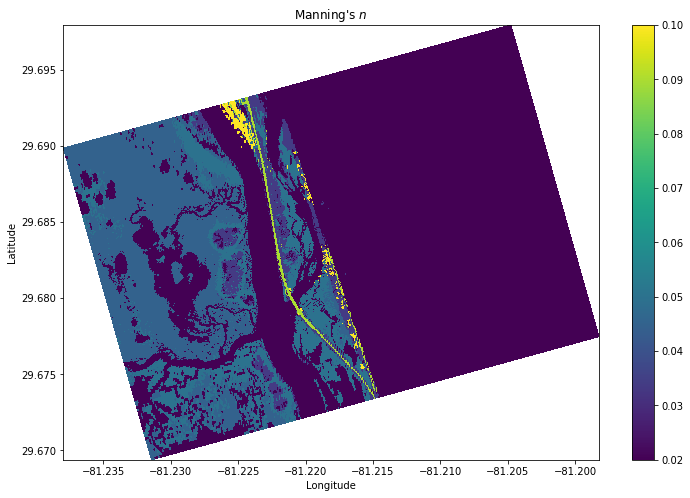

In [16]:
fig = plt.figure(figsize=[12,8])
plt.pcolormesh(lon,lat,cnmapi)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.colorbar()
plt.title('Manning\'s $n$')

Text(0.5,1,'Elevation (m)')

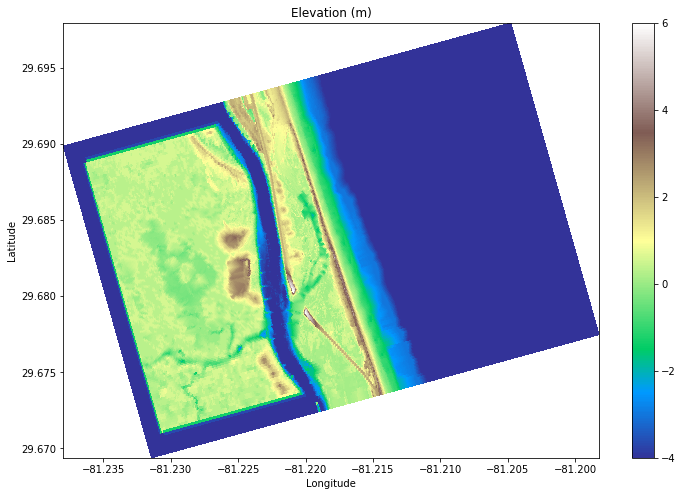

In [17]:
fig = plt.figure(figsize=[12,8])
plt.pcolormesh(lon,lat,dep,vmin=-4,vmax=6,cmap=plt.cm.terrain )
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.colorbar()
plt.title('Elevation (m)')